In [55]:
import pyomo.environ as pe
import pandas as pd
import numpy as np

### Data

In [56]:
demand = {1  : 17,    2  : 84,    3  : 55,    4  : 30,    5  : 29,    6  : 22,    7  : 34,    8  : 85,    9  :  6,    10 : 50,
11 : 99,    12 : 57,    13 : 99,    14 : 76,    15 : 13,    16 : 63,    17 : 15,    18 : 25,    19 : 66,    20 : 43,
21 : 35,    22 : 35,    23 : 13,    24 : 15,    25 : 58,    26 : 83,    27 : 23,    28 : 66,    29 : 77,    30 : 30,
31 : 11,    32 : 50,    33 : 16,    34 : 87,    35 : 26,    36 : 28,    37 : 59,    38 : 72,    39 : 62,    40 : 46,
41 : 41,    42 : 11,    43 : 31,    44 :  4,    45 : 33,    46 : 18,    47 : 64,    48 : 56,    49 : 76,    50 : 29,
51 : 66,    52 : 75,    53 : 62,    54 : 28,    55 :  8,    56 : 10,    57 : 64,    58 : 54,    59 :  3,    60 : 79,
61 :  7,    62 : 17,    63 : 52,    64 : 75,    65 : 17,    66 :  3,    67 : 58,    68 : 62,    69 : 38,    70 : 35,
71 : 24,    72 : 24,    73 : 13,    74 : 93,    75 : 37,    76 : 78,    77 : 30,    78 : 12,    79 : 74,    80 :  6,
81 : 20,  82:0,  83 : 26,    84 : 49,    85 : 15,    86 : 17,    87 : 33,    88 : 31,    89 : 32,    90 : 96,    91 : 99,
92 : 36,    93 : 37,    94 : 77,    95 : 39,    96 : 91,    97 : 11,    98 : 73,    99 :  5,    100: 57}

### Parameters

In [57]:
invCap = 1000        # inventory capacity
maxQ = 1000          # max order quantity
orderCost = 500      # cost for each order
holdCost = 2         # holding cost (per unit, per time period)
leadtime = 10        # lead time
backLogCost = 10     # backlogged orders penalty (per unit, per time period)
maxBackLogged = 1000 # big-M
initialInv = 500     # initial inventory

### Model

In [58]:
m = pe.ConcreteModel()

In [59]:
# sets
m.time = pe.Set(initialize = pe.RangeSet(1,100))

In [60]:
# devision variables
m.Q  = pe.Var(bounds=[0,maxQ],domain = pe.NonNegativeReals)
m.R = pe.Var(bounds=[0,invCap],domain = pe.NonNegativeReals)
m.inv = pe.Var(m.time,bounds=[0,invCap],domain = pe.NonNegativeReals)
m.back = pe.Var(m.time,bounds = [0,maxBackLogged],domain = pe.NonNegativeReals)
m.low = pe.Var(m.time,domain = pe.Binary)
m.order = pe.Var(m.time,domain = pe.Binary)
m.repl = pe.Var(m.time,domain = pe.NonNegativeReals)
m.delta = pe.Var(m.time,domain = pe.Binary)

In [61]:
# objective

def objective(model):
    return orderCost * sum(m.order[t] for t in m.time) + holdCost * sum(m.inv[t] for t in m.time) + backLogCost * sum(m.back[t] for t in m.time)
m.objective = pe.Objective(rule = objective, sense = pe.minimize)

In [62]:
# constraints

# inventory balance
def inv_balance(model,t):
    if t == 1:
        return m.inv[t] - m.back[t] == m.repl[t] + initialInv - demand[t]
    else:
        return m.inv[t] - m.back[t] == m.inv[t-1] - m.back[t-1] - demand[t] + m.repl[t]
m.inv_balance = pe.Constraint(m.time,rule = inv_balance)

# inventory cap delta
def inv_cap_delta(model,t):
    return m.inv[t] <= invCap * m.delta[t]
m.inv_cap_delta = pe.Constraint(m.time,rule = inv_cap_delta)

# backlogged
def back_cap(model,t):
    return m.back[t] <= maxBackLogged * (1-m.delta[t])
m.back_cap = pe.Constraint(m.time,rule=back_cap)

# inventory low first constraint
def inv_low_1(model,t):
    return m.inv[t] <= m.R + invCap * (1 - m.low[t])
m.inv_low_1 = pe.Constraint(m.time,rule=inv_low_1)

# inventory low second constraint
def inv_low_2(model,t):
    return m.inv[t] >= m.R + 1 - (invCap + 1) * m.low[t]
m.inv_low_2 = pe.Constraint(m.time,rule = inv_low_2)

# inventory reorder first constraint
def reorder_1(model,t):
    if t > 1:
        return m.order[t] <= 1 - m.low[t-1]
    else:
        return m.order[t] <= 1
m.reorder_1 = pe.Constraint(m.time,rule = reorder_1)

# inventory reorder second constraint
def reorder_2(model,t):
    return m.order[t] <= m.low[t]
m.reorder_2 = pe.Constraint(m.time,rule = reorder_2)

# inventory reorder third constraint
def reorder_3(model,t):
    if t > 1:
        return m.order[t] >= m.low[t] - m.low[t-1]
    else:
        return m.order[t] >= m.low[t]
    
# inventory replenish first constraint   
def inv_replen(model,t):
    if t > leadtime:
        return m.repl[t] <= maxQ * m.order[t-leadtime]
    else:
        return m.repl[t] <= 0
m.inv_replen = pe.Constraint(m.time,rule = inv_replen)

# inventory replenish second constraint 
def inv_replen_2(model,t):
    return m.repl[t] <= m.Q
m.inv_replen_2 = pe.Constraint(m.time,rule=inv_replen_2)

# inventory replenish third constraint 
def inv_replen_3(model,t):
    if t > leadtime:
        return m.repl[t] >= m.Q - maxQ * (1 - m.order[t-leadtime])
    else:
        return m.repl[t] >= m.Q - maxQ
m.inv_replen_3 = pe.Constraint(m.time,rule = inv_replen_3)

In [63]:
optimizer = pe.SolverFactory('cbc')

In [64]:
results = optimizer.solve(m,options = {"threads":4},tee = True)

Welcome to the CBC MILP Solver 
Version: 2.10.5 
Build Date: Dec  8 2020 

command line - /home/victormoura/anaconda3/envs/iff_opt/bin/cbc -threads 4 -printingOptions all -import /tmp/tmp04dq3dzz.pyomo.lp -stat=1 -solve -solu /tmp/tmp04dq3dzz.pyomo.soln (default strategy 1)
threads was changed from 0 to 4
Option for printingOptions changed from normal to all
Presolve 959 (-42) rows, 582 (-21) columns and 2476 (-102) elements
Statistics for presolved model
Original problem has 300 integers (300 of which binary)
Presolved problem has 300 integers (300 of which binary)
==== 292 zero objective 5 different
292 variables have objective of 0
90 variables have objective of 2
90 variables have objective of 10
10 variables have objective of 12
100 variables have objective of 500
==== absolute objective values 5 different
292 variables have objective of 0
90 variables have objective of 2
90 variables have objective of 10
10 variables have objective of 12
100 variables have objective of 500
==== f

In [65]:
inv = m.inv.extract_values()

In [66]:
col = ['time','inventory']
df = pd.DataFrame(columns=col)
for ivalues in inv.keys():
    df = pd.concat([df,
                    pd.DataFrame.from_records([{
                                col[0]:ivalues,
                                col[1]:inv[ivalues]
                            }])],ignore_index=True)

In [67]:
supply = m.repl.extract_values()

In [68]:
col = ['time','supply']
df_ = pd.DataFrame(columns=col)
for ivalues in supply.keys():
    df_ = pd.concat([df_,
                    pd.DataFrame.from_records([{
                                col[0]:ivalues,
                                col[1]:supply[ivalues]
                            }])],ignore_index=True)

In [69]:
col = ['time','demand']
df_demand = pd.DataFrame(columns=col)
for ivalues in demand.keys():
    df_demand = pd.concat([df_demand,
                    pd.DataFrame.from_records([{
                                col[0]:ivalues,
                                col[1]:demand[ivalues]
                            }])],ignore_index=True)

In [70]:
import matplotlib.pyplot as plt

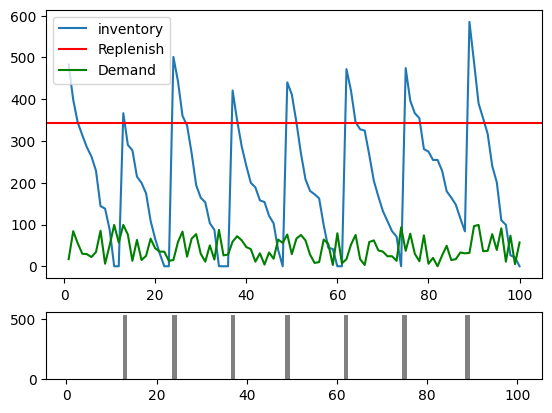

In [73]:
f, (a0,a1) = plt.subplots(2,1,gridspec_kw={'height_ratios': [1, 1/4]})

a0.plot(df['time'],df['inventory'])
a0.axhline(y = m.R(),color = 'r')
a0.plot(df_demand['time'],df_demand['demand'], color = 'g')
a0.legend(['inventory','Replenish','Demand'])
a1.bar(df_['time'],df_['supply'],color ='#808080',width = 1)
plt.show()